In [1]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive/MyDrive/Intro_to_AI_assignment

# Import libraries and data

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import math
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import plotly.express as px


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer




df = pd.read_csv('coursework_other.csv', delimiter=',')

In [3]:
def meta_info():
    df.info()      #prints the meta information of the dataset 
    
    
def corr_plot(data = None):
    plt.figure(figsize=(10,6))    
    sns.set_style('whitegrid')
    corr = abs(data.corr())       #since only the magnitude of the correlation will be considered
    mask = np.triu(np.ones_like(corr, dtype=bool))   #to only display the lower triangle for aesthetic purposes
    sns.heatmap(corr, mask = mask,cmap = 'Blues', annot = True)   
    plt.show()
    
    
def split_date(data=None):  #split the date column into usable components
    data['day_of_week'] = pd.to_datetime(data.Date, format = '%d/%m/%Y').dt.day_name()
    data['day'] = pd.to_datetime(data.Date, format = '%d/%m/%Y').dt.day
    data['month'] = pd.to_datetime(data.Date, format = '%d/%m/%Y').dt.month_name()
    data['year'] = pd.to_datetime(data.Date, format = '%d/%m/%Y').dt.year.astype(object)
    return data.drop(columns = ['Date'])
    
    
    
def boxplots(data=None):    #plot boxplots for all the numeric columns
    cat_col = data.columns[data.apply(lambda x: x.dtype) == 'O']
    num_col = list(set(data.columns) - set(cat_col)- set(['Hour', 'day']))


    fig, ax = plt.subplots(nrows=2, ncols=4, figsize = (20,10))

    for col, subplot in zip(num_col, ax.ravel()):
        sns.boxplot(data = data.loc[:,num_col], 
                    y = col, orient='v', ax=subplot, palette = 'Spectral')
    plt.show()

    
    
    
def univariate_plots(data = None):    #plot countplot for categorical and histogram for numeric columns
    time_col = ['year', 'day', 'month', 'day_of_week','Hour', 'Seasons' ]
    #Exclude time columns as these will have uniform distributions


    fig, ax = plt.subplots(nrows=4, ncols=3, figsize = (20,20))  
    #a grid to plot distributions of all variables at once


    #loop over every variable and axes object to plot on corresponding axes
    for col, subplot in zip(data.loc[:,~data.columns.isin(time_col)], ax.ravel()):  
        if data[col].dtype == 'O':                                              #for object types, use countplot
            sns.countplot(data = data, x = col,  ax=subplot, palette = 'Spectral', edgecolor='black')
        else:                                                                 #for others, plot histograms
            sns.histplot(data = data, x = col, kde= True, ax=subplot, color = 'green', edgecolor = 'white')

    plt.show()    
    
def bivariate_plots(data=None):
    plt.figure(figsize=(25,25))      #Check the impact of every variable on the target variable
    for col, plot in zip(data.drop(columns=['Rented Bike Count']).columns, range(1,18)):

        if data[col].dtype == 'O':

            plt.subplot(6,3,plot)
            sns.barplot(data = data.groupby(by=col).median().reset_index(),
                        x = col, y = 'Rented Bike Count',
                        palette = 'Spectral', edgecolor='black')
            plt.xticks(rotation = 25)

        else:

            plt.subplot(6,3,plot)
            sns.scatterplot(data = data, 
                            x = col, y = 'Rented Bike Count', hue='Seasons', alpha=0.5,  
                            color = 'green', edgecolor = 'white')   #hue to include seasonal information as well
            
            
def naive_encode(data=None):
    encoder = LabelEncoder()     #label encode with any consideration to the meaning of the values
    return data.apply(lambda x: encoder.fit_transform(x) if x.dtype == 'O' else x)

def split_data(data=None):    #returs a dictionary with test and train sets
    X = data.drop(columns=['Rented Bike Count'])
    y = data['Rented Bike Count']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
    datasets = dict({'X_train':X_train, 'X_test':X_test, 'y_train':y_train, 'y_test':y_test})

    return datasets


#trains model on train set and returns metrics on test and train set
def model_metrics(model=None, datasets=None):
    model.fit(datasets['X_train'], datasets['y_train'])  #training on train set
    pred = model.predict(datasets['X_test'])             #predictions on test set
    mse = mean_squared_error(datasets['y_test'], pred)
    mae = mean_absolute_error(datasets['y_test'], pred)
    r_squared = model.score(datasets['X_test'], datasets['y_test'])   #evaluation metrics on test set
    
    pred_train = model.predict(datasets['X_train'])      #predictions on train
    mse_train = mean_squared_error(datasets['y_train'], pred_train)
    mae_train = mean_absolute_error(datasets['y_train'], pred_train)
    r_squared_train = model.score(datasets['X_train'], datasets['y_train']) #evaluation metrics on train set
    
    metrics = pd.Series([mse, mae, r_squared, mse_train, mae_train, r_squared_train], 
                        index = ['MSE','MAE','R_squared','mse_train','mae_train','r_squared_train'])
    
    return metrics    #returns a series with index reflecting the corresponding metric

# EDA

In [4]:
meta_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      8760 non-null   object 
 1   Rented Bike Count         8760 non-null   int64  
 2   Hour                      8760 non-null   int64  
 3   Temperature(C)            8760 non-null   float64
 4   Humidity(%)               8760 non-null   int64  
 5   Wind speed (m/s)          8760 non-null   float64
 6   Visibility (10m)          8760 non-null   int64  
 7   Dew point temperature(C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)   8760 non-null   float64
 9   Rainfall(mm)              8760 non-null   float64
 10  Snowfall (cm)             8760 non-null   float64
 11  Seasons                   8760 non-null   object 
 12  Holiday                   8760 non-null   object 
 13  Functioning Day           8760 non-null   object 
dtypes: float

- None of the columns seem to have any null values and the datatypes are consistent with what we see in the values of the head of the dataframe
- The dataset is a mix of nominal(eg. Holiday), ordinal(eg. Seasons) discrete(eg. Hour) and continuous(eg. Temperature(C)) variables


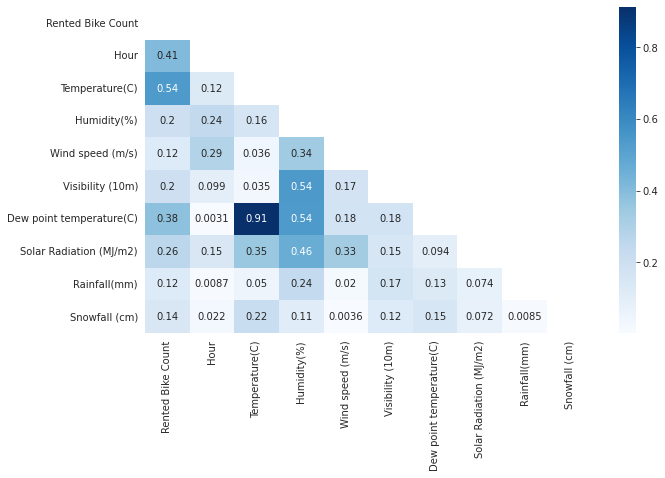

In [5]:
corr_plot(data=df)

- Dew point temperature has a very high correlation with temperature
- Hour of the day and temperature seem to be strong predictors
- Every variable has some non-trivial correlation with the dependant variable ('Rented Bike Count')

In [6]:
df_split_date = split_date(data=df)
df_split_date.sample(3)

Rented Bike Count  Hour  Temperature(C)  Humidity(%)  Wind speed (m/s)  \
371                 239    11            -5.2           30               4.0   
2883                264     3            10.7           74               1.7   
8012               1186    20             7.6           59               1.1   

      Visibility (10m)  Dew point temperature(C)  Solar Radiation (MJ/m2)  \
371               1991                     -20.1                     0.86   
2883               712                       6.2                     0.00   
8012              2000                       0.0                     0.00   

      Rainfall(mm)  Snowfall (cm) Seasons     Holiday Functioning Day  \
371            0.0            0.0  Winter  No Holiday             Yes   
2883           0.0            0.0  Spring  No Holiday             Yes   
8012           0.0            0.0  Autumn  No Holiday             Yes   

     day_of_week  day     month  year  
371     Saturday   16  December  2017  
2883    Saturday   31     March  2018  
8012     Tuesday   30   October  2018

- Instead of the 'Date' column, we now have four new columns(the 4 right most columns) derived from the 'Date' column

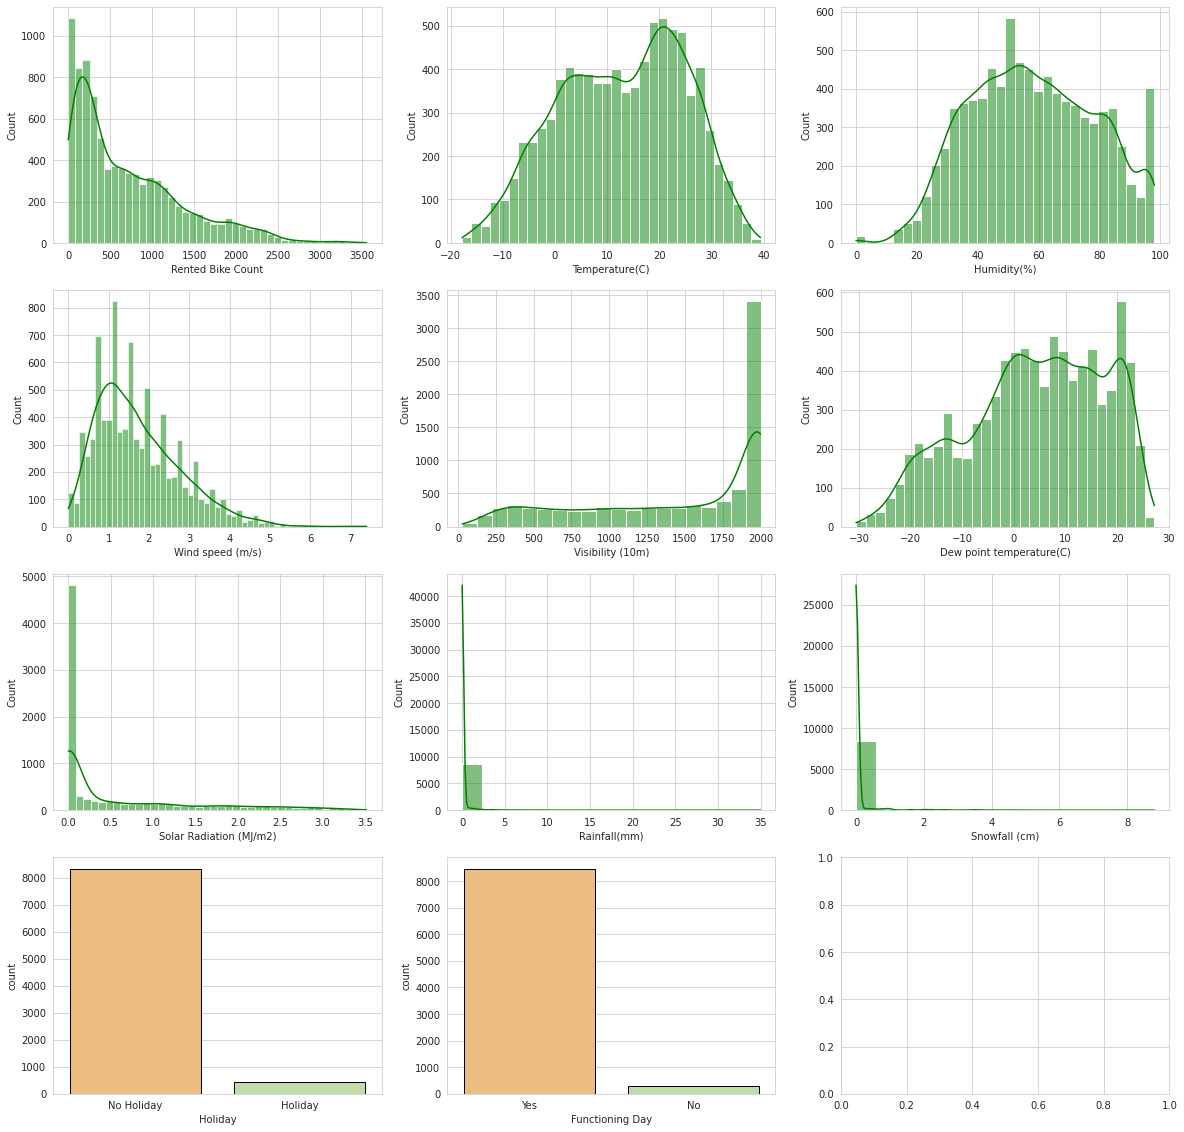

In [7]:
univariate_plots(data=df_split_date)

- Dependant variable is heavily right skewed
- Temperature and Humidity are reasonably normal
- Solar radiation, rainfall and snowfall seem to have lot of relatively rare occurances
- There is hardly any variance in 'Holiday' and 'Functioning Day' but might be usefull

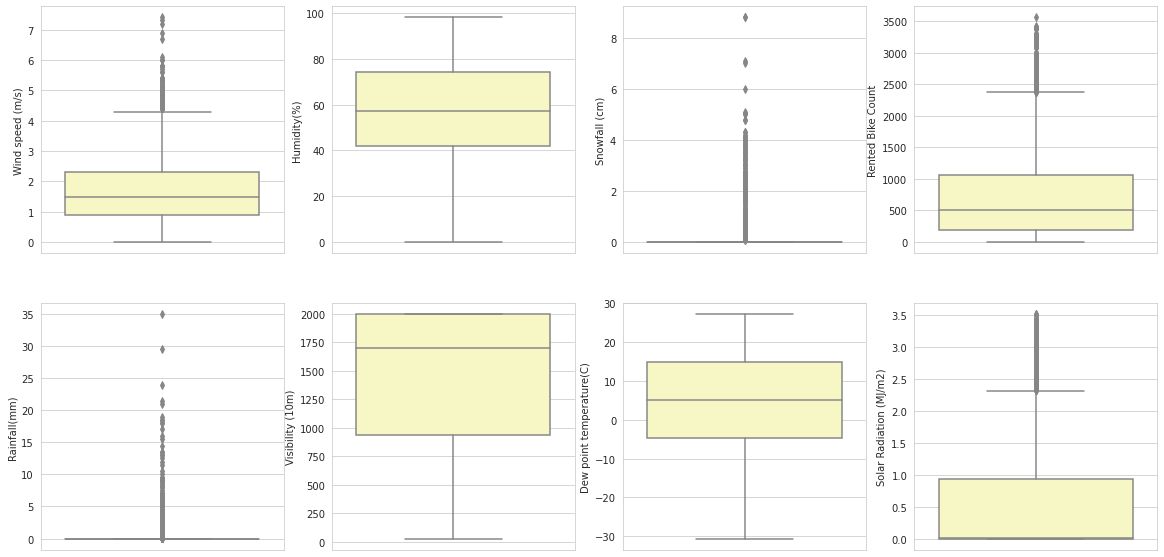

In [8]:
boxplots(data=df_split_date)

- Data doesn't conform to the normality assumption of Linear regression

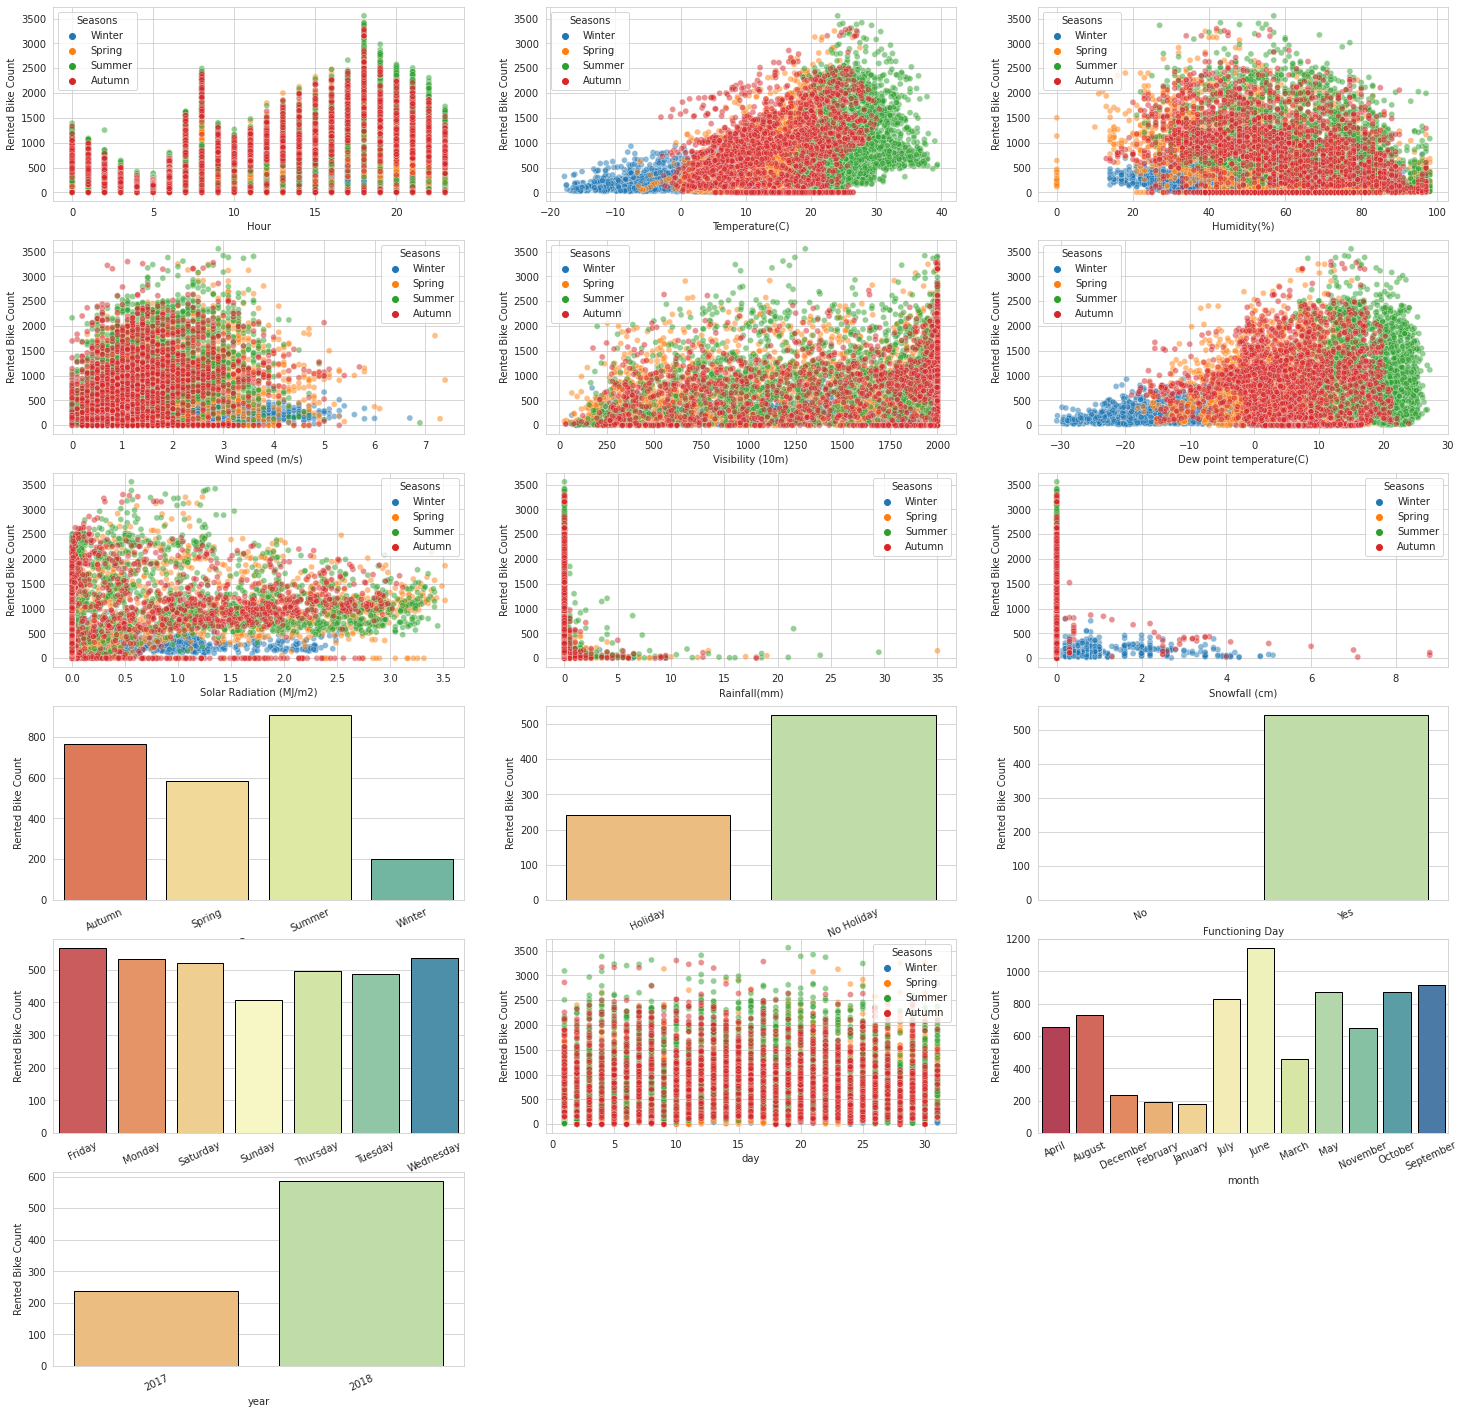

In [9]:
bivariate_plots(data=df_split_date)

- Every plot above shows the number of bikes rented for any given value of the independant variable
- No bikes are rented when 'Functioing Day' is 'No'
- Sunday seems to be the least popular day for bike rentals and Friday being the most popular
- There has been an approximately 2.5x increase in bike rentals from 2017 to 2018 but, we only have data from December 1st of 2017 hence it is not a usefull comparision
- Summer months see a high rental activity and it tapers down at the winter months. The trend seems consistent throughout the year. Same is reflected in the Seasons
- Activity is 2x for a 'No-Holiday' day than for a 'Holiday'
- Bike renting peaks around 9am in the morning and 8pm in the evening with the evening peak being significantly higher
- The other scatterplots do not seem very benificial to infer any insights

## Iteration 1 - Baseline
#### (negligible preprocessing of data and default parameters for out-of-box models)

In [10]:
''' dropping a few columns as they do not add additional value.
 'year' is not useful because the dataset comprises data of only one year from Dec2017 to Nov2018. 
 There are no instances in 2017 that can be directly compared with any instance in 2018. 
 'Seasons' is just another version months but with lesser detail
 'Dew point temperature' is highly correlated 91% with 'Temperature' hence, essentially containing the same info
 '''

encoded_df = naive_encode(data=df_split_date)
encoded_df.drop(columns=['year', 'Seasons', 'Dew point temperature(C)'],inplace=True)
encoded_df.head(3)

Rented Bike Count  Hour  Temperature(C)  Humidity(%)  Wind speed (m/s)  \
0                254     0            -5.2           37               2.2   
1                204     1            -5.5           38               0.8   
2                173     2            -6.0           39               1.0   

   Visibility (10m)  Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm)  \
0              2000                      0.0           0.0            0.0   
1              2000                      0.0           0.0            0.0   
2              2000                      0.0           0.0            0.0   

   Holiday  Functioning Day  day_of_week  day  month  
0        1                1            0    1      2  
1        1                1            0    1      2  
2        1                1            0    1      2

- There are no strings in the dataset, only numerical values

In [11]:
#Split data into test and train sets
data = split_data(encoded_df)


#verifying the shape of the test and train sets
list(map(lambda x: f'{x} --> {data[x].shape}', data.keys()))  

['X_train --> (6570, 13)',
 'X_test --> (2190, 13)',
 'y_train --> (6570,)',
 'y_test --> (2190,)']

In [12]:
#Performance of models with default parameters

models = dict({'baseline_model': DummyRegressor(),
               'Linear_regression': LinearRegression(),
               'Decision_tree': DecisionTreeRegressor(),
               'Random_forest': RandomForestRegressor(),
               'Xgboost': XGBRegressor()})

metrics = pd.DataFrame(columns= ['MSE','MAE','R_squared','mse_train','mae_train','r_squared_train'])

for model in models.keys():
    metrics.loc[model, :] = model_metrics(model = models[model], datasets = data)
metrics

MSE         MAE R_squared      mse_train  \
baseline_model     411193.049604  515.141129 -0.000145  417572.957327   
Linear_regression  184065.813969  318.357991  0.552296  186607.159466   
Decision_tree        63093.66484  147.879452  0.846537            0.0   
Random_forest       37734.883444  113.528598  0.908217    4744.763257   
Xgboost             29827.090813  100.314742  0.927452    4529.512033   

                    mae_train r_squared_train  
baseline_model     521.227342             0.0  
Linear_regression  324.148461        0.553115  
Decision_tree             0.0             1.0  
Random_forest       41.919242        0.988637  
Xgboost             45.222826        0.989153

In [13]:
metrics.to_csv('metrics_1.csv')

- The above metrics are a result of using the dataset without much preprocessing and encoding the categorical columns simply in alphabetical order
- All the models used above have been run using their default hyperparameters
- Xgboost gives the best results for this iteration
- There is a noticeable amount of overfitting happening with all the tree based models - decision tree, random forest and xgboost. The overfit decision tree is facing is significant

## Iteration 2 - Finetuning
#### (Random forest and Xgboost)

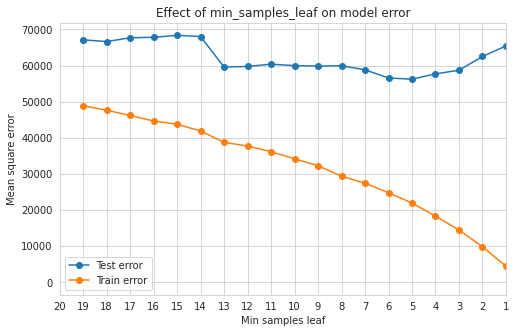

In [21]:
min_sample_leaf = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
mse_scores_test = []
mse_scores_train = []

for size in min_sample_leaf:
    model = DecisionTreeRegressor(min_samples_leaf=size)
    model.fit(data['X_train'],data['y_train'])
    mse_scores_test.append(mean_squared_error(data['y_test'], model.predict(data['X_test'])))
    mse_scores_train.append(mean_squared_error(data['y_train'], model.predict(data['X_train'])))
plt.figure(figsize=(8,5))
plt.plot(mse_scores_test, '-o', label = 'Test error')
plt.plot(mse_scores_train, '-o', label= 'Train error')
plt.xlim((20,1))
plt.xticks(min_sample_leaf)
plt.legend()
plt.xlabel("Min samples leaf")
plt.ylabel("Mean square error")
plt.title("Effect of min_samples_leaf on model error")
plt.show()

- The plot above shows the effect of a changing hyperparameter in the mean squared error
- However, decision tree is a simple model and tends to overfit. For a more generalizable model we pick an ensemble model. In this case, a Random Forest

In [16]:
param_grid = { 
    'min_samples_leaf': [1, 4, 8, 12, 16, 20, 24],
    'max_depth' : [5,20,35,50,65,80],
}

rf = RandomForestRegressor(random_state=1)

score_func = make_scorer(mean_squared_error, greater_is_better=False) #definig custom scoring function


rf_cv = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5,   
                     return_train_score=True, n_jobs=-1, scoring = score_func)

rf_cv.fit(data['X_train'], data['y_train'])

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [5, 20, 35, 50, 65, 80],
                         'min_samples_leaf': [1, 4, 8, 12, 16, 20, 24]},
             return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [17]:
result = pd.DataFrame({'max_depth' : [combo['max_depth'] for combo in rf_cv.cv_results_['params']],
                      'min_samples_leaf': [combo['min_samples_leaf'] for combo in rf_cv.cv_results_['params']],
                      'train_scores': abs(rf_cv.cv_results_['mean_train_score']),
                      'test_scores': abs(rf_cv.cv_results_['mean_test_score'])})


fig = px.line_3d(result, x="max_depth", y="min_samples_leaf", z="train_scores")


fig.show()

- MSE scores on the training sets from the cross-validation performed by grid search, plotted against the two varing hyperparameters

In [18]:
fig = px.line_3d(result, x="max_depth", y="min_samples_leaf", z="test_scores")

fig.show()

- MSE scores on the validation sets from the cross-validation performed by grid search, plotted against the two varing hyperparameters
- Note: these test scores are not based on the X_test and y_test, but rather on validation sets derived from X_train and y_train

In [19]:
results_best = (result.train_scores == result.train_scores.min()) & (result.test_scores == result.test_scores.min())
result[results_best]

max_depth  min_samples_leaf  train_scores   test_scores
14         35                 1   5246.239769  37561.003622
21         50                 1   5246.239769  37561.003622
28         65                 1   5246.239769  37561.003622
35         80                 1   5246.239769  37561.003622

- The above results show the parameters at which the model had least average mse for test and train validation sets

In [29]:
rf = RandomForestRegressor(min_samples_leaf=1, max_depth= 35, random_state=1)

final = pd.DataFrame(model_metrics(model = rf, datasets=data),columns=['Random forest fine tuned']).T

final

MSE         MAE  R_squared    mse_train  \
Random forest fine tuned  37593.483595  113.680566   0.908561  4770.270811   

                          mae_train  r_squared_train  
Random forest fine tuned  41.979152         0.988576

In [30]:
final.to_csv('final.csv')

- Performance of the model with the parameters obtained from GridSearchCV on the actual test set

# Conclusion

**- Due to limited computation, only a small set of parameters were iterated over**

**- However, the process can be repeated with a more exhaustive set of parameters**

**- First iterate over a broader range of parameters with larger intervals (coarse tuning)**

**- Fine tuning can follow post coarse tuning with a narrow range of parameters and small intervals**
